## Оценка количества точек на изображении
Т.к. необходимо получить информацию из изображения, будем использовать библиотеку компьютерного зрения OpenCV + Python

#### Подключение библиотек

In [1]:
import cv2
import numpy as np
import requests
import os
import matplotlib.pyplot as plt
from IPython.display import Image

#### Загрузка исходного изображения и сохранение в файл

In [2]:
url = 'https://lh5.googleusercontent.com/yO12GARP3fqmNOZ00zM9Q_nyBVWWfR_xVu8skrvAmhB1hzSJyq_F593jhQqS48aWJyCZ5jzDAQ=w513'
p = requests.get(url)
with open('points.jpg', 'wb') as f:
    f.write(p.content)

#### Откроем

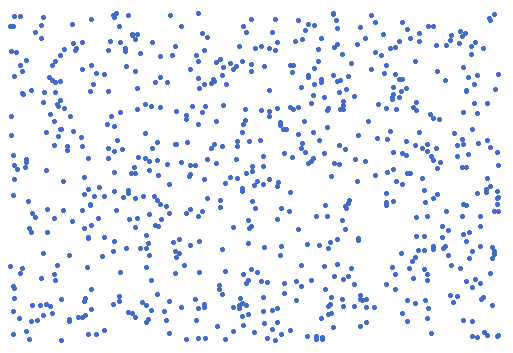

In [3]:
Image('points.jpg')

#### Увеличим размер изображения

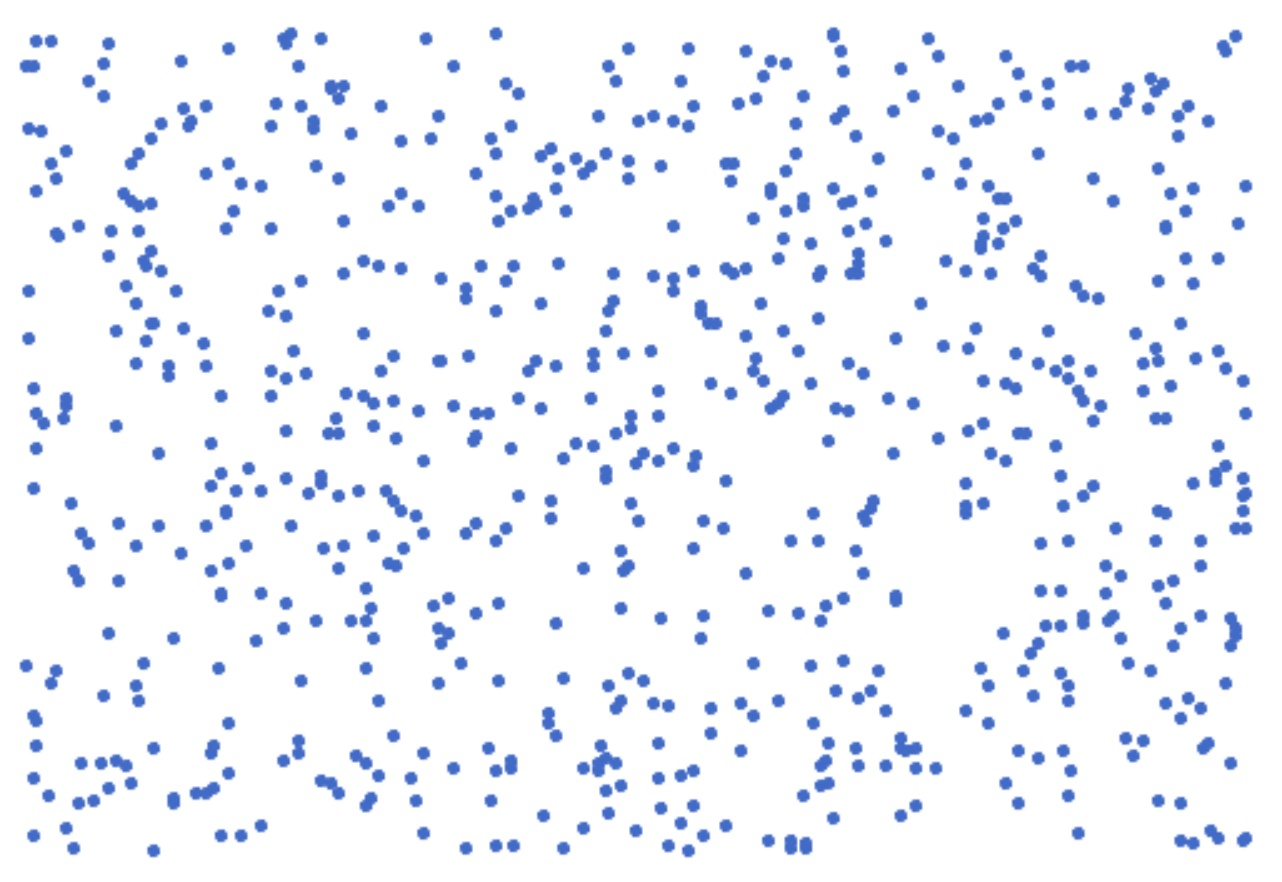

In [4]:
im = cv2.imread("points.jpg")    # считываем изображение как массив
im_resized = cv2.resize(im, (int(im.shape[1]*2.5), int(im.shape[0]*2.5)), cv2.INTER_AREA)    # увеличиваем размер
if not os.path.exists('temp'):    # создаем директорию temp для промежуточных изображений
    os.mkdir('temp')
cv2.imwrite(r'temp\resized.jpg', im_resized)    # записываем в файл
Image(r'temp\resized.jpg')    # открываем

Точки одного цвета, хорошо выделяются на монотонном фоне.<br>
Размер каждой отдельной точки варьируется не сильно. Но присутствуют точки, расположенные друг относительно друга с наложением.<br>
Низкое качество изображения и наличие наложений дадут много ошибок при поиске определенного образа (круга) на изображении.<br>
Поэтому попробуем искать замкнутые контуры и анализировать их площадь.

Для того, чтобы искать контуры, необходимо провести предварительную подготовку изображения.

#### Конвертируем изображение из цветного в "серое"

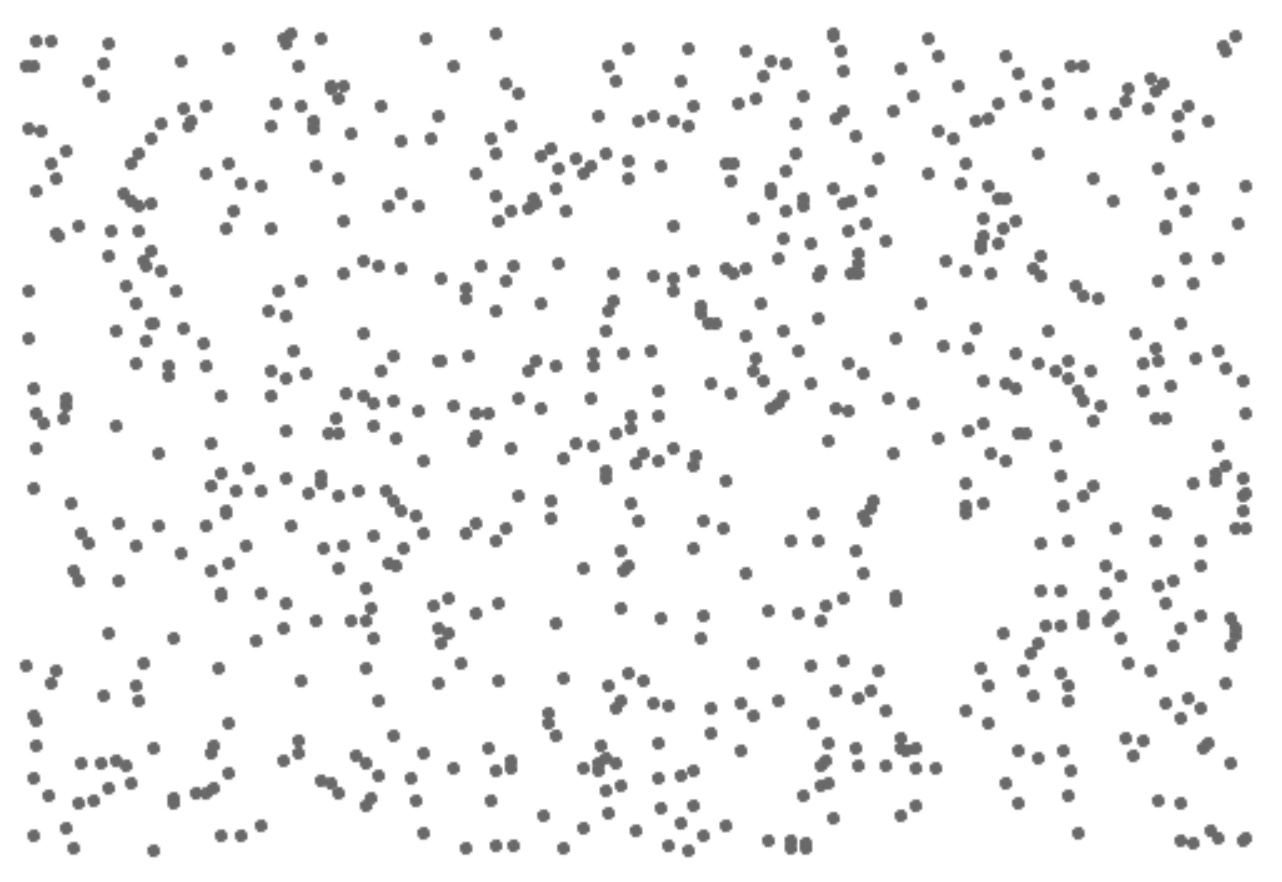

In [5]:
imgray = cv2.cvtColor(im_resized,cv2.COLOR_BGR2GRAY)    # конвертируем из цветного в "серое"
cv2.imwrite(r'temp\gray.jpg', imgray)    # записываем в файл и открываем
Image(r'temp\gray.jpg')

#### Конвертируем "серое" изображение в бинарное (каждый пиксель 0 или 1)

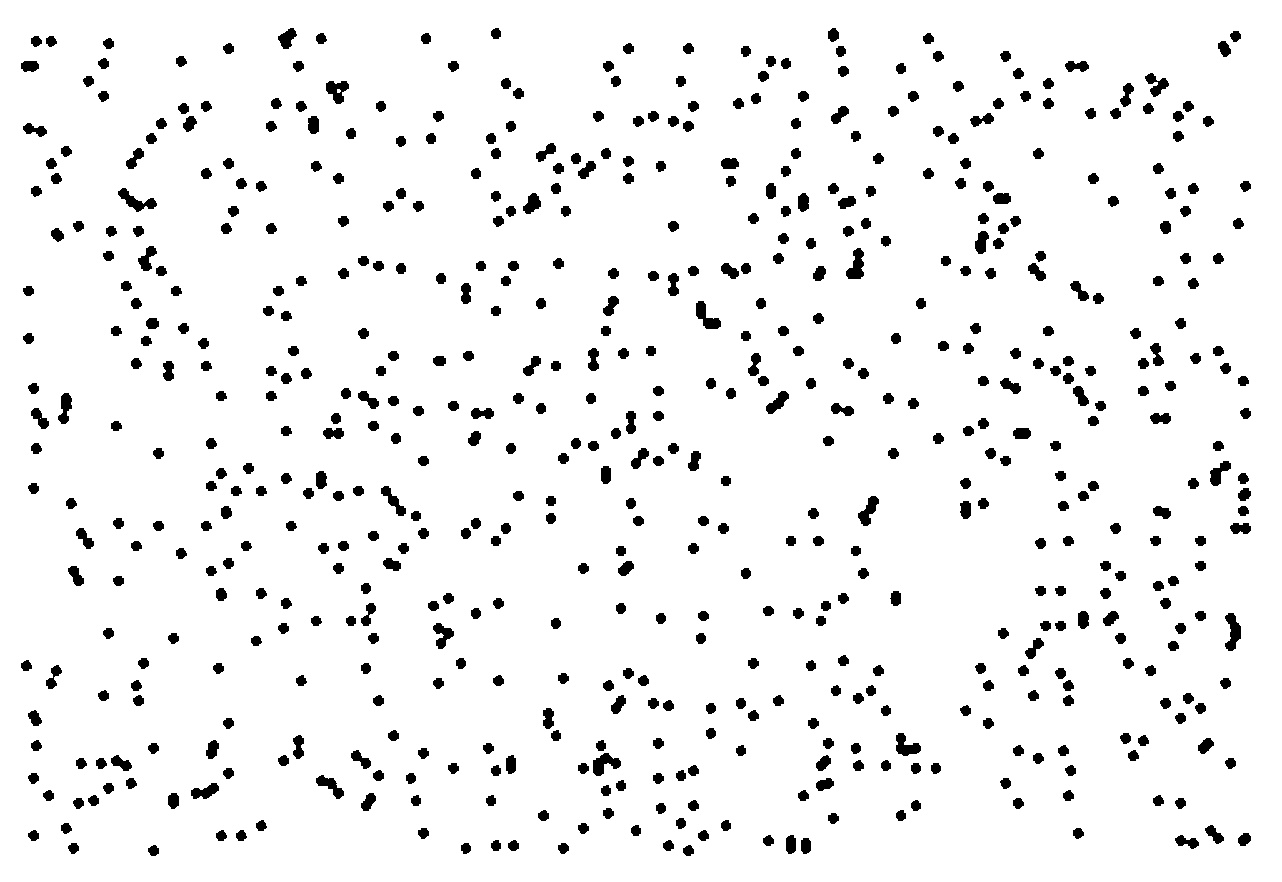

In [6]:
ret,thresh = cv2.threshold(imgray,127,255,0)    # конвертируем из "серого" в бинарное
cv2.imwrite(r'temp\thresh.jpg', thresh)    # записываем в файл и открываем
Image(r'temp\thresh.jpg')

#### Находим контуры на изображении. Координаты границ контуров записываем в список contours

In [7]:
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

#### Отобразим контуры
Покажем контуры красным цветом на "сером" изображении

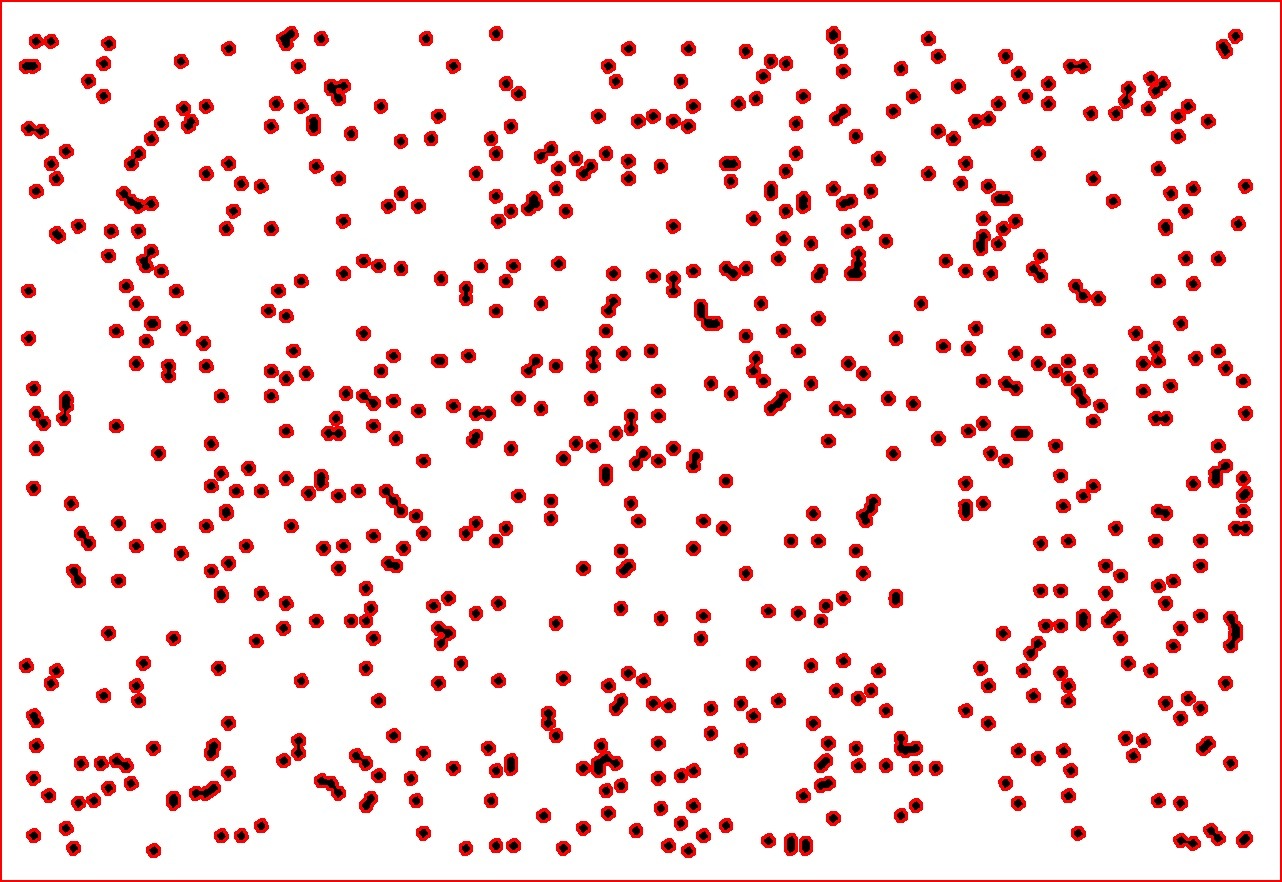

In [8]:
imgray2 = cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR)    # конвертируем бинарное изображение в цветное
cv2.drawContours(imgray2, contours, -1, (0,0,255), 2)    # рисуем контуры красным цветом
cv2.imwrite(r'temp\contours.jpg', imgray2)    # сохраняем в файл и открываем
Image(r'temp\contours.jpg')

#### Проализируем площади контуров
Для этого построим гистограмму распределения площадей

Amount of contours : 603


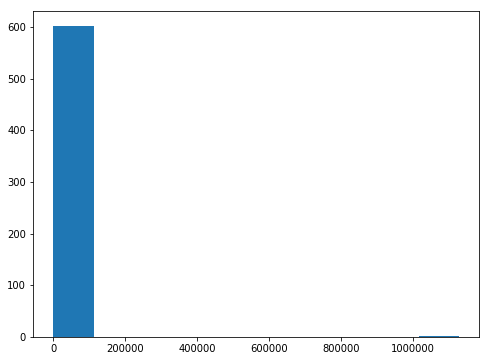

In [9]:
area_list = []
for i in range(len(contours)):    # создаем список площадей контуров
    area_list.append(cv2.contourArea(contours[i]))
print('Amount of contours :', len(area_list))
%matplotlib inline
# выводим гистограмму
plt.figure(figsize=(8, 6))
plt.hist(area_list)
plt.show()

В данных присутствует выброс - контур с очень большой площадью. Это прямоугольный контур всего изображения (см. предыдущее изображение)

#### Избавляемся от выброса

In [10]:
area_list.sort()    # сортируем список площадей контуров
area_list.pop(-1)    # удаляем контур с максимальной площадью
print(area_list[:10])

[0.0, 8.0, 98.0, 98.0, 98.0, 98.0, 99.5, 99.5, 99.5, 99.5]


Видим, что также присутствуют 2 выброса в меньшую сторону. Избавляемся.

In [11]:
area_list = area_list[2:]    # срезаем два первых элемента из сортированного списка площадей

Снова построим гистограмму

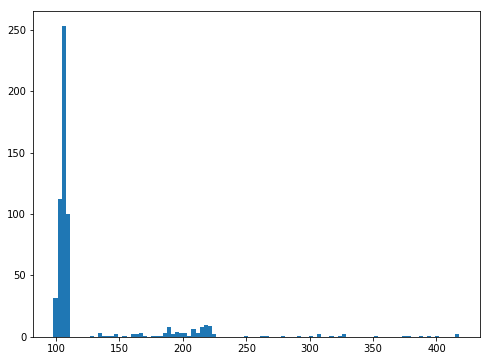

In [12]:
# выводим гистограмму
plt.figure(figsize=(8, 6))
plt.hist(area_list, bins=100)
plt.show()

#### Определим площадь отдельной точки
Больше всего контуров имеют площадь в районе 100.<br> Это контуры отдельных точек на изображении (т.к. отдельных точек гораздо больше чем групповых). <br>Рассмотрим эту область гистограммы.

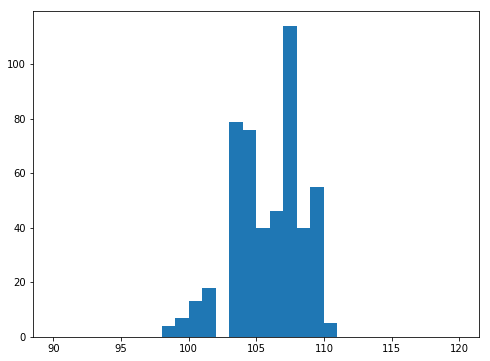

In [13]:
# выводим гистограмму в диапазоне 90..120
plt.figure(figsize=(8, 6))
plt.hist(area_list, bins=30, range=(90, 120))
plt.show()

Площадь отдельной точки на изображении лежит в диапазоне примерно 97..112<br>
За предельные расчетные значения площадей отдельной точки принимаем 95 и 113

In [14]:
max_area_of_point = 113    # макс. значение площади отдельной точки
min_area_of_point = 95    # мин. значение площади отдельной точки

#### Определим из скольких точек состоит максимальная группа (точки с наложениями)

In [15]:
max_area = max(area_list)
print(max_area / max_area_of_point)

3.6991150442477876


#### Считаем общее количество точек

Имеем максимальную группу из 4 точек.<br>
Поэтому распределяем контуры на 4 группы (по площадям) и считаем общее количество точек.<br>
Рисуем разным цветом контуры, включающие в себя разное количество точек (для визуального контроля результата):
 - конутр с 1 точкой - красный<br>
 - контур с 2 точками - голубой<br>
 - контур с 3 точками - желтый<br>
 - контур с 4 точками - зеленый<br>


In [16]:
points = 0

for k in range(len(contours)):
    if min_area_of_point < cv2.contourArea(contours[k]) <= max_area_of_point:
        cv2.drawContours(im_resized, contours[k], -1, (0,0,255), 2)    # 1 точка, красный контур
        points += 1
    elif max_area_of_point < cv2.contourArea(contours[k]) <= max_area_of_point * 2:
        cv2.drawContours(im_resized, contours[k], -1, (255,255,0), 2)    # 2 точки, голубой контур
        points += 2
    elif max_area_of_point * 2 < cv2.contourArea(contours[k]) <= max_area_of_point * 3:
        cv2.drawContours(im_resized, contours[k], -1, (0,255,255), 2)    # 3 точки, жёлтый конту
        points += 3
    elif max_area_of_point * 3 < cv2.contourArea(contours[k]) <= max_area_of_point * 4:
        cv2.drawContours(im_resized, contours[k], -1, (0,255,0), 2)    # 4 точки, зелёный контур
        points += 4

#### Выводим результат

Amount of points : 731


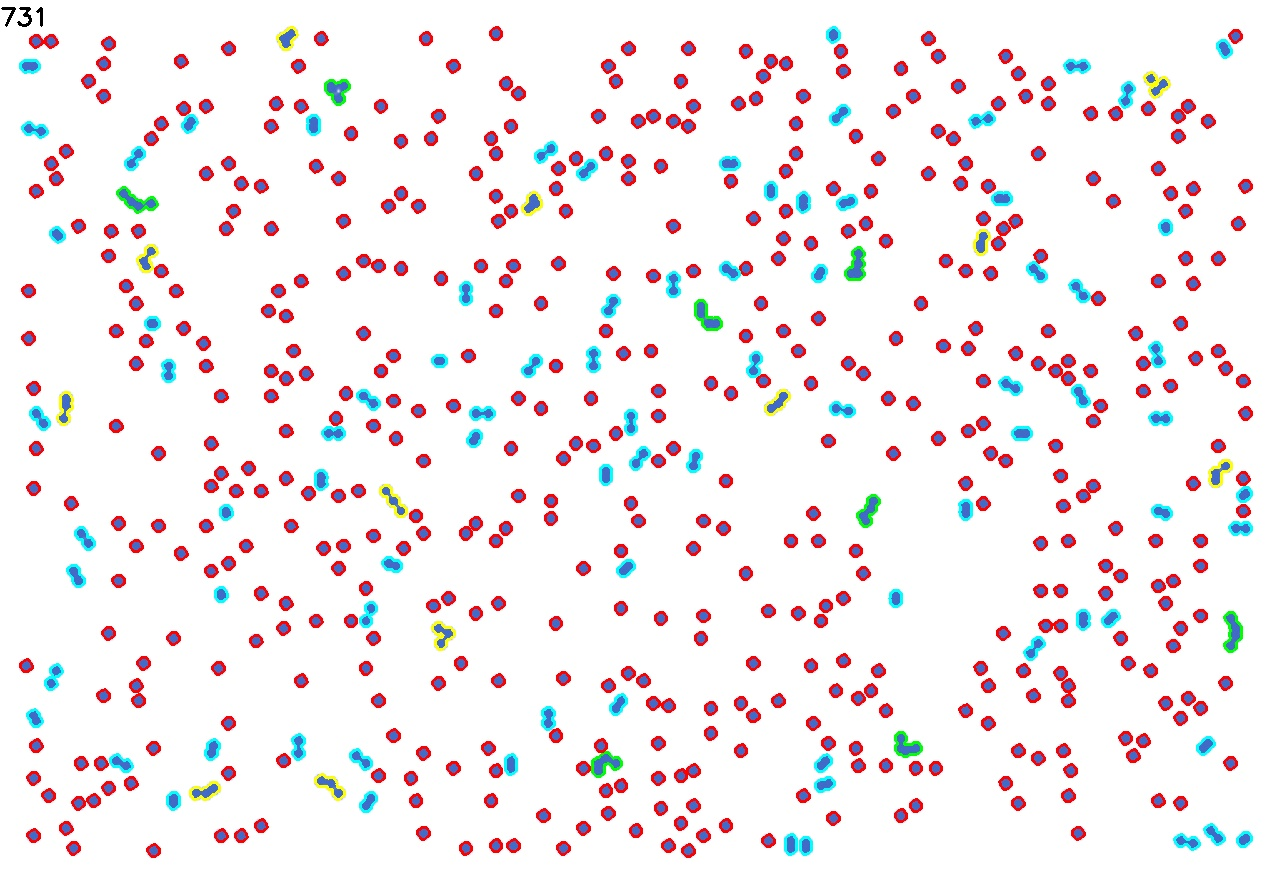

In [17]:
cv2.putText(im_resized, str(points),
            (0, 25), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.8, (0, 0, 0), 2)    # добавляем текст на изображение
cv2.imwrite('result.jpg', im_resized)    # записываем результат в файл
print('Amount of points :', points)    # выводим итоговое количество точек
Image('result.jpg')    # выводим результирующее изображение

#### Итог
В итоге посчитана 731 точка. Визуально контуры выделились корректно. Но стоит обратить внимание на то, что при большой степени наложения точек друг на друга могут возникнуть ошибки в подсчете количества (большее количество точек может быть принято за меньшее). Поэтому, вероятно, действительное количество точек на изображении может быть больше.